In [64]:
import copy
from typing import List, Tuple, Union

import networkx as nx
import numpy as np
import torch
import torch.utils.data
from torch import diag, from_numpy, lt
from tqdm import tqdm

from torch_geometric.data import Batch, Data
from torch_geometric.data.dataset import Dataset, IndexType
from torch_geometric.utils import from_networkx, to_networkx


class GMixupDataset:
    r"""A wrapper class around a dataset that applies G-Mixup data augmentation
    to its base dataset.

    G-Mixup data augmentation technique is implemented as proposed in the paper
    "G-Mixup: Graph Data Augmentation for Graph Classification" by Xiaotian
    Han, Zhimeng Jiang, Ninghao Liu, Xia Hu in 2022.

    Args:
        base_dataset (Dataset): The dataset to apply G-Mixup to.
        log (bool, optional): Whether to print any console output while
            processing the dataset. (default: :obj:`True`)
        align_graphs (bool, optional): Whether to align the graphs by node
            degree before generating graphons. This is generally recommended to
            ensure graphon invariance to node ordering, but can be turned off
            for speed if it is known that the input graphs are already aligned.
            (default: :obj:`True`)
        threshold (float, optional): The threshold to use for singular value
            thresholding when generating graphons. Typically ranges from 2-3.
            (default: :obj:`2.02`)
        generate_graphons (bool, optional): Whether to generate graphons for
            the dataset during initialization or on-the-fly. Note that
            generating graphons for the dataset during initialization can be
            slow for large datasets. (default: :obj:`True`)
        sample_num (int, optional): How many graphs to sample from a class when
            approximating graphon for that class. Default value of -1 means to
            use all available graphs from that class. (default: :obj:`-1`)
    """
    def __init__(
        self,
        base_dataset: Dataset,
        log: bool = True,
        align_graphs: bool = True,
        threshold: float = 2.02,
        generate_graphons: bool = True,
        sample_num: int = -1,
    ) -> None:
        self.base_dataset = base_dataset
        self.log = log
        self.align_graphs = align_graphs
        self.threshold = threshold
        self.sample_num = sample_num

        self.graphs_by_class = [
            np.empty(0, dtype=int)
            for _ in range(self.base_dataset.num_classes)
        ]
        for i, data in enumerate(self.base_dataset):
            label = data.y.item()
            self.graphs_by_class[label] = np.append(
                self.graphs_by_class[label], i)

        self.max_node_count = int(
            np.max([data.num_nodes for data in self.base_dataset]))
        self.graphons = np.zeros((
            self.base_dataset.num_classes,
            self.max_node_count,
            self.max_node_count,
        ))
        self.graphons_generated = torch.zeros(self.base_dataset.num_classes,
                                              dtype=torch.bool)

        if generate_graphons:
            self.generate_graphons()
        else:
            if self.log:
                print("Graphons not generated during initialization."
                      "Graphons will be generated on-the-fly, or you can call"
                      "generate_graphons() to generate them all at once.\n")

    def generate_graphons(self) -> None:
        """Generates graphons for all classes in the dataset.

        If GMixupDataset was initialized with generate_graphons=False,
        generate_graphons() can be (optionally) manually called to generate
        graphons for all classes in the dataset. This can be useful if
        generate_graphons=False was used to speed up initialization, but
        graphons are needed later on.

        If generate_graphons is not called, graphons will be generated
        on-the-fly when needed by the generate_graphs.
        """
        if self.log:
            print("Generating graphons for "
                  f"{self.base_dataset.num_classes}classes...\n")

        for i in range(self.base_dataset.num_classes):
            if self.graphons_generated[i]:
                if self.log:
                    print(
                        f"Graphon for class {i} already generated, skipping..."
                    )
                continue
            else:
                self.generate_graphon(i)

        return None

    def align_graphs_by_degree(
        self, graph_adjs: List[np.ndarray]
    ) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
        num_nodes = [graph_adj.shape[0] for graph_adj in graph_adjs]
        max_num = max(num_nodes)
        min_num = min(num_nodes)

        aligned_adjs = []
        normalized_node_degrees = []
        for graph_adj in graph_adjs:
            curr_n = graph_adj.shape[0]
            node_degree = 0.5 * np.sum(graph_adj, axis=0) + 0.5 * np.sum(
                graph_adj, axis=1)
            node_degree /= np.sum(node_degree)
            perm = np.argsort(node_degree)  # ascending
            perm = perm[::-1]  # descending

            sorted_node_degree = node_degree[perm]
            sorted_node_degree = sorted_node_degree.reshape(-1, 1)

            sorted_graph = copy.deepcopy(graph_adj)
            sorted_graph = sorted_graph[perm, :]
            sorted_graph = sorted_graph[:, perm]

            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:curr_n, :] = sorted_node_degree
            aligned_adj = np.zeros((max_num, max_num))
            aligned_adj[:curr_n, :curr_n] = sorted_graph
            normalized_node_degrees.append(normalized_node_degree)
            aligned_adjs.append(aligned_adj)
        return aligned_adjs, normalized_node_degrees, max_num, min_num

    def generate_graphon(self, class_idx: int) -> np.ndarray:
        if self.graphons_generated[class_idx]:
            if self.log:
                print(f"Graphon for class {class_idx} already "
                      "generated, skipping...")
            return self.graphons[class_idx]

        num_graphs_of_class = len(self.graphs_by_class[class_idx])
        if self.sample_num > 0 and num_graphs_of_class > self.sample_num:
            class_sample = np.random.choice(self.graphs_by_class[class_idx],
                                            self.sample_num, replace=False)
        else:
            class_sample = self.graphs_by_class[class_idx]
        class_adj_mats = [
            nx.to_numpy_array(to_networkx(self.base_dataset[graph_index]))
            for graph_index in class_sample
        ]

        if self.align_graphs:
            aligned_graphs, normalized_node_degrees, max_num, min_num = (
                self.align_graphs_by_degree(class_adj_mats))
            class_adj_mats = aligned_graphs

        graph_tensor_np = np.array(class_adj_mats)
        graph_tensor = from_numpy(graph_tensor_np).float()

        if self.log:
            print(f"Generating graphon for class {class_idx} with "
                  f"{graph_tensor.size(0)} graphs...")

        final_graphon = None
        count = 0
        for agg_graph_adj in tqdm(graph_tensor):
            # normalize adjacency matrix to be in interval [-1, 1]
            agg_graph_adj_normalized = 2 * agg_graph_adj - 1

            # svd graphon estimation \cite{Chatterjee}
            U, S, Vh = torch.linalg.svd(agg_graph_adj_normalized)

            num_nodes = agg_graph_adj.size(0)
            num_edges = torch.sum(agg_graph_adj == 1)
            proportion_edges = num_edges / (num_nodes**2) / 2

            scaled_thresh = self.threshold * (
                (num_nodes * proportion_edges)**0.5)
            S[lt(S, scaled_thresh)] = 0

            graphon = U @ diag(S) @ Vh

            graphon[graphon >= 1] = 1  # clip
            graphon[graphon <= -1] = -1  # clip
            # renormalize graphon to be in interval [0, 1]
            graphon = (graphon + 1) / 2
            graphon = torch.nn.functional.interpolate(
                graphon.unsqueeze(0).unsqueeze(0),
                size=(self.max_node_count, self.max_node_count),
                mode="bilinear",
                align_corners=False,
            ).squeeze()

            if final_graphon is None:
                final_graphon = graphon
            else:
                final_graphon = (final_graphon * count + graphon) / (count + 1)
            count += 1

        self.graphons[class_idx] = final_graphon.numpy()
        self.graphons_generated[class_idx] = True

        if self.log:
            print(f"Graphon for class {class_idx} generated.")
            print(f"graphon avg = {torch.mean(final_graphon)}, "
                  f"original avg = {torch.mean(graph_tensor)}. "
                  "These should be close.\n")

        return graphon.numpy()

    def generate_graphs(
        self,
        idx_1: Union[int, np.integer, IndexType],
        idx_2: Union[int, np.integer, IndexType],
        mixing_param: Union[float, np.float64, IndexType] = 0.5,
        K: Union[int, np.integer, IndexType] = 10,
        method: str = "random",
        size: Union[int, np.integer, IndexType] = 1,
    ) -> Batch:
        r"""Generates synthetic graph(s) using G-Mixup.

        We allow indexing with a tensor, numpy array, Python slicing, or a
        single integer index. Similarly, we allow mixing_param, K, and size to
        be either a singular value or a numpy array or tensor of values. If any
        of these are a tensor, they must be of the same length as size.

        Args:
            idx_1 (int, array, tensor): Index of the first class of graphs
            idx_2 (int, array, tensor): Index of the second graph of graphs
            mixing_param (float, array, tensor): The mixing parameter λ to use
                when interpolating the graphons of the two classes.
                Varied between 0 and 1 to generate graphs that are more similar
                to the first class (λ = 0) or the second class (λ = 1).
                (default: :obj:`0.5`)
            K (int, array, tensor): The number of nodes to sample for the
                ouput synthetic graph(s)
            method (str): The method to use for sampling nodes from the
                graphon. Can be 'random' to sample nodes uniformly at random,
                or 'uniform' to guarantee a uniform distribution of nodes
                across the graph. (default: :obj:`'random'`)
            size (int, array, tensor): number of synthetic graphs to generate
                (default: :obj:`1`)

        Returns:
            Batch: 'size' synthetic graphs generated using G-Mixup.
        """
        assert method in ["random", "uniform"], \
            "Graph generation method must be 'random' or 'uniform'"
        expected_indextype_length = size \
            if isinstance(size, Union[int, np.integer]) \
            else len(size.flatten().tolist())
        if isinstance(idx_1, IndexType):
            idx_1 = idx_1.flatten().tolist()
            assert len(idx_1) == expected_indextype_length, \
                "idx_1 must be an integer or a tensor of length 'size'"
        if isinstance(idx_2, IndexType):
            idx_2 = idx_2.flatten().tolist()
            assert len(idx_2) == expected_indextype_length, \
                "idx_2 must be an integer or a tensor of length 'size'"
        if isinstance(mixing_param, IndexType):
            mixing_param = mixing_param.flatten().tolist()
            assert len(mixing_param) == expected_indextype_length, \
                "mixing_param must be a float or a tensor of length 'size'"
        if isinstance(K, IndexType):
            K = K.flatten().tolist()
            assert len(K) == expected_indextype_length, \
                "K must be an integer or a tensor of length 'size'"

        graphs = []
        if isinstance(size, IndexType):
            for i, size_i in enumerate(size.flatten().tolist()):
                idx_1_i = idx_1[i] if isinstance(idx_1, IndexType) else idx_1
                idx_2_i = idx_2[i] if isinstance(idx_2, IndexType) else idx_2
                mixing_param_i = mixing_param[i] if isinstance(
                    mixing_param, IndexType) else mixing_param
                K_i = K[i] if isinstance(K, IndexType) else K

                graphs.append(
                    self.generate_graphs(idx_1_i, idx_2_i, mixing_param_i, K_i,
                                         method, size_i))
        else:
            if self.log:
                print(
                    f"Generating {size} synthetic graph(s) for indices {idx_1}"
                    f" and {idx_2} with mixing parameter {mixing_param} and "
                    f"{K} nodes...")

            for i in range(size):
                idx_1_i = idx_1[i] if isinstance(idx_1, IndexType) else idx_1
                idx_2_i = idx_2[i] if isinstance(idx_2, IndexType) else idx_2
                mixing_param_i = mixing_param[i] if isinstance(
                    mixing_param, IndexType) else mixing_param
                K_i = K[i] if isinstance(K, IndexType) else K

                if not self.graphons_generated[idx_1_i]:
                    if self.log:
                        print(
                            f"Graphon for class {idx_1_i} not yet generated, "
                            "generating...")
                    self.generate_graphon(idx_1_i)
                if not self.graphons_generated[idx_2_i]:
                    if self.log:
                        print(
                            f"Graphon for class {idx_2_i} not yet generated, "
                            "generating...")
                    self.generate_graphon(idx_2_i)

                graph = self.generate_graph(idx_1_i, idx_2_i, mixing_param_i,
                                            K_i, method)
                graphs.append(graph)

        return Batch.from_data_list(graphs)

    def generate_graph(
        self,
        idx_1: int,
        idx_2: int,
        mixing_param: float = 0.5,
        K: int = 10,
        method: str = "random",
    ) -> Data:
        graphon1 = self.graphons[idx_1]
        graphon2 = self.graphons[idx_2]
        mixed_graphon = mixing_param * graphon1 + (1 - mixing_param) * graphon2

        u_values = None
        u_values_index = None
        if method == "random":
            u_values = np.random.uniform(0, 1, K)
            u_values.sort()
            u_values_index = (u_values * mixed_graphon.shape[0]).astype(int)
        elif method == "uniform":
            u_values = np.linspace(0, 1, K, endpoint=False)
            u_values_index = (u_values * mixed_graphon.shape[0]).astype(int)
        else:
            raise ValueError("Invalid method")

        adjacency_matrix = np.zeros((K, K))
        for i in range(K):
            for j in range(K):
                p = mixed_graphon[u_values_index[i], u_values_index[j]]
                if np.random.rand() < p:
                    adjacency_matrix[i, j] = 1

        graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
        graph_pyg = from_networkx(graph)

        if self.log:
            print("Synthetic graph(s) generated.\n")

        return graph_pyg

    def __getattr__(self, name: str):
        if name in self.__dict__:
            return getattr(self, name)
        else:
            return getattr(self.base_dataset, name)


In [65]:
from torch_geometric.datasets import GNNBenchmarkDataset

gnn_benchmark = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')
gmixup_gnn_benchmark = GMixupDataset(gnn_benchmark)

Generating graphons for 10classes...

Generating graphon for class 0 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3041.41it/s]


Graphon for class 0 generated.
graphon avg = 0.11567791551351547, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 1 with 15 graphs...


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 2670.51it/s]


Graphon for class 1 generated.
graphon avg = 0.11144312471151352, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 2 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 2978.49it/s]


Graphon for class 2 generated.
graphon avg = 0.12372516840696335, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 3 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3119.21it/s]


Graphon for class 3 generated.
graphon avg = 0.12302249670028687, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 4 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3690.00it/s]


Graphon for class 4 generated.
graphon avg = 0.1266970932483673, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 5 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3603.97it/s]


Graphon for class 5 generated.
graphon avg = 0.12481062114238739, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 6 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3714.84it/s]


Graphon for class 6 generated.
graphon avg = 0.12500157952308655, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 7 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3333.40it/s]


Graphon for class 7 generated.
graphon avg = 0.11931084096431732, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 8 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3384.50it/s]


Graphon for class 8 generated.
graphon avg = 0.12836943566799164, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 9 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3870.95it/s]

Graphon for class 9 generated.
graphon avg = 0.1259157806634903, original avg = 0.09756097197532654. These should be close.



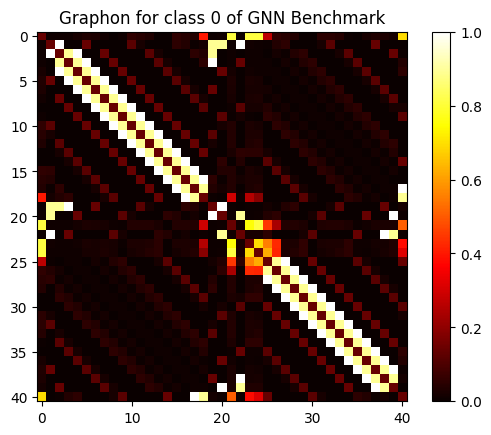

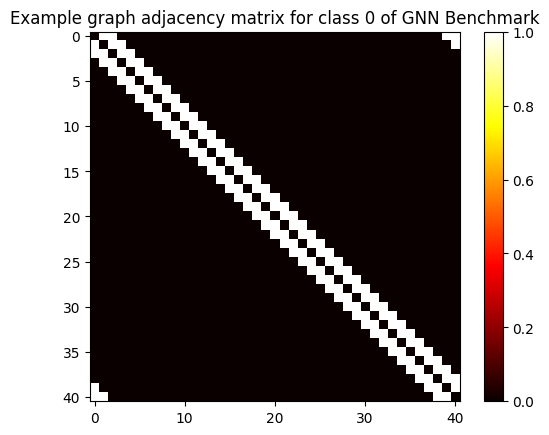

In [66]:
import matplotlib.pyplot as plt
plt.imshow(gmixup_gnn_benchmark.graphons[0], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 0 of GNN Benchmark")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[0][0]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 0 of GNN Benchmark")
plt.show()

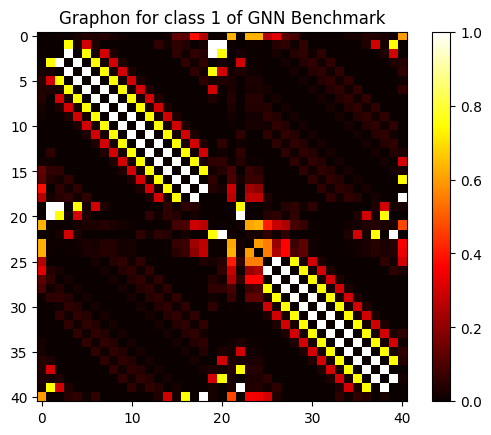

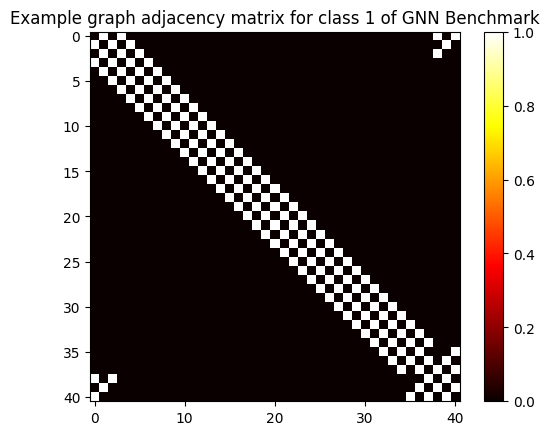

In [6]:
plt.imshow(gmixup_gnn_benchmark.graphons[1], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 1 of GNN Benchmark")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[1][5]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 1 of GNN Benchmark")
plt.show()

Generating 1 synthetic graph(s) for indices 0 and 0 with mixing parameter 0 and 41 nodes...
Synthetic graph(s) generated.

DiGraph with 41 nodes and 164 edges
graph real average degree:  4.0
Drawing Real Label 0 graph...
DiGraph with 41 nodes and 191 edges
graph gen average degree:  4.658536585365853
Drawing Generated Label 0 graph...


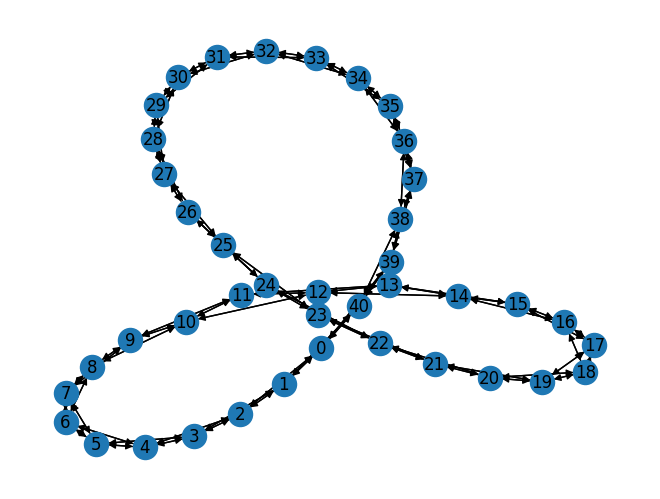

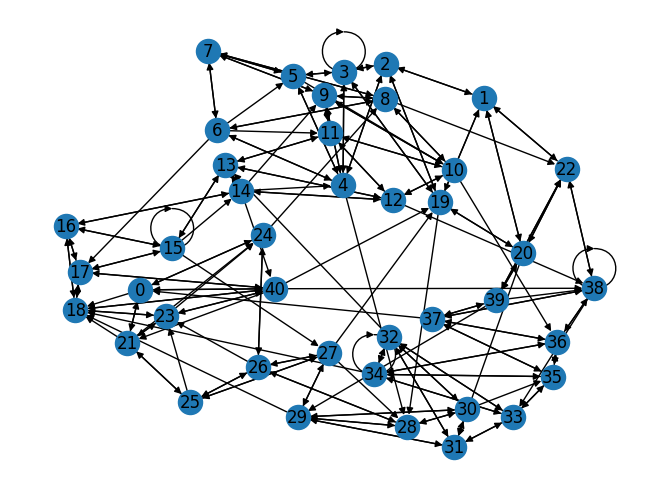

In [67]:
graph_real = to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[0][0]])
graph_gen = to_networkx(gmixup_gnn_benchmark.generate_graphs(0, 0, 0, K=41, method='uniform'))
# graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 1, 1)


import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values()))/2)
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values()))/2)
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

In [68]:
graph_real = to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[0][0]])
graph_gen = (gmixup_gnn_benchmark.generate_graphs(idx_1 = np.array([0, 1]), idx_2 = 1, mixing_param=0.5, K=41, method='uniform', size=np.array([2, 1])))
# graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 1, 1)

print(graph_gen)
# import matplotlib.pyplot as plt
# print(graph_real)
# print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values()))/2)
# print("Drawing Real Label 0 graph...")
# plt.figure(1)
# nx.draw(graph_real, with_labels=True)
# plt.figure(2)
# print(graph_gen)
# print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values()))/2)
# print("Drawing Generated Label 0 graph...")
# nx.draw(graph_gen, with_labels=True)

Generating 2 synthetic graph(s) for indices 0 and 1 with mixing parameter 0.5 and 41 nodes...
Synthetic graph(s) generated.

Synthetic graph(s) generated.

Generating 1 synthetic graph(s) for indices 1 and 1 with mixing parameter 0.5 and 41 nodes...
Synthetic graph(s) generated.

DataBatch(edge_index=[2, 593], weight=[593], num_nodes=123, batch=[123])


Generating 1 synthetic graph(s) for indices 1 and 1 with mixing parameter 0 and 41 nodes...
Synthetic graph(s) generated.

DiGraph with 41 nodes and 164 edges
graph real average degree:  4.0
Drawing Real Label 1 graph...
DiGraph with 41 nodes and 175 edges
graph gen average degree:  4.2682926829268295
Drawing Generated Label 1 graph...


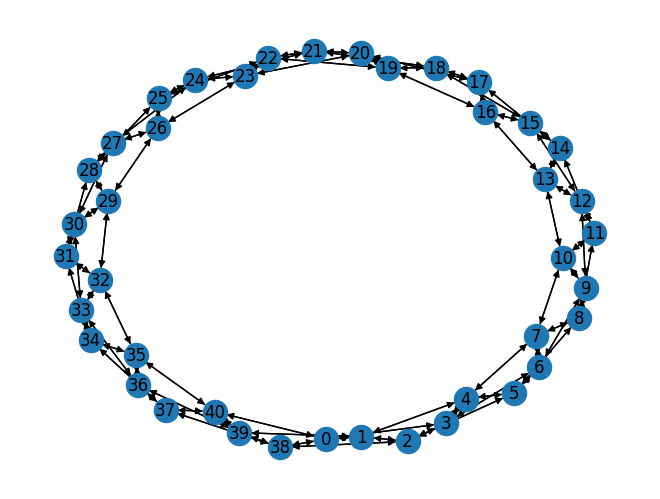

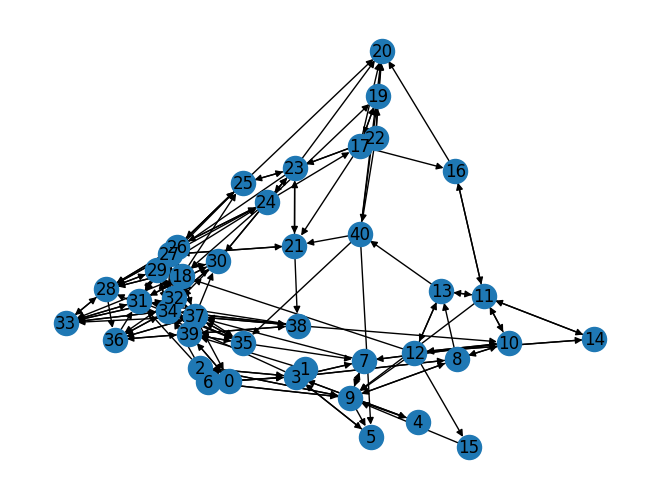

In [ ]:
graph_real = to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[1][5]])
graph_gen = to_networkx(gmixup_gnn_benchmark.generate_graphs(1, 1, 0, K=41, method='random'))
# graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 1, 1)


import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values()))/2)
print("Drawing Real Label 1 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values()))/2)
print("Drawing Generated Label 1 graph...")
nx.draw(graph_gen, with_labels=True)

In [9]:
mnist = torch_geometric.datasets.MNISTSuperpixels(root="tmp/mnist")


In [10]:
gmixup_mnist = GMixupDataset(mnist, log=True, generate_graphons=False, sample_num=20)

Graphons not generated during initialization. Graphons will be generated on-the-fly, or you can call generate_graphons() to generate them all at once.



In [11]:
gmixup_mnist.graphs_by_class[0]

array([    1,    21,    34, ..., 59952, 59972, 59987])

Graphon for class 0 not yet generated, generating...
Generating graphon for class 0 with 20 graphs...


100%|██████████| 20/20 [00:00<00:00, 1644.89it/s]

Graphon for class 0 generated.
graphon avg = 0.25724124908447266, original avg = 0.2345244437456131. These should be close.

Generating 1 synthetic graph(s) for indices 0 and 0 with mixing parameter 0 and 75 nodes...
Synthetic graph(s) generated.

DiGraph with 75 nodes and 1260 edges
graph real average degree:  33.6
Drawing Real Label 0 graph...


DiGraph with 75 nodes and 1546 edges
graph gen average degree:  41.22666666666667
Drawing Generated Label 0 graph...


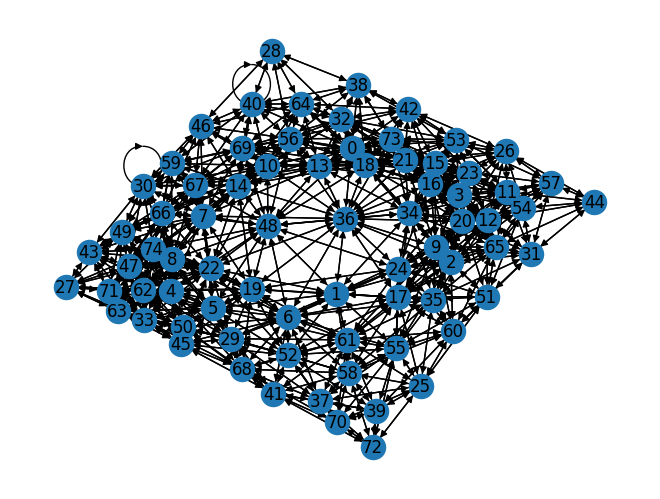

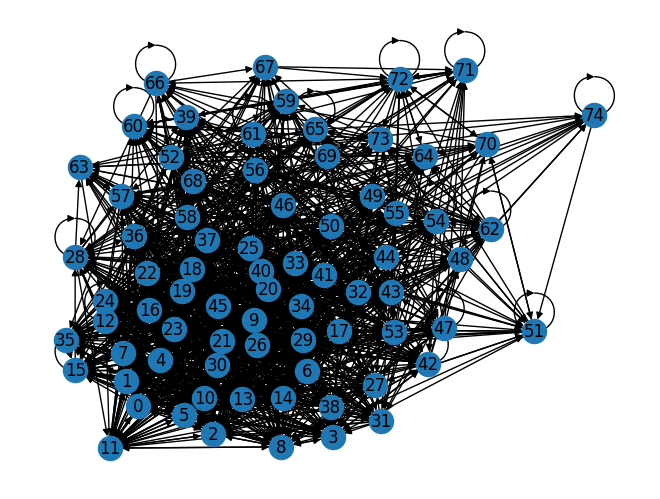

In [12]:
graph_real = to_networkx(gmixup_mnist.base_dataset[gmixup_mnist.graphs_by_class[0][0]])
graph_gen = to_networkx(gmixup_mnist.generate_graphs(0, 0, 0, K=75))

import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values())))
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values())))
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

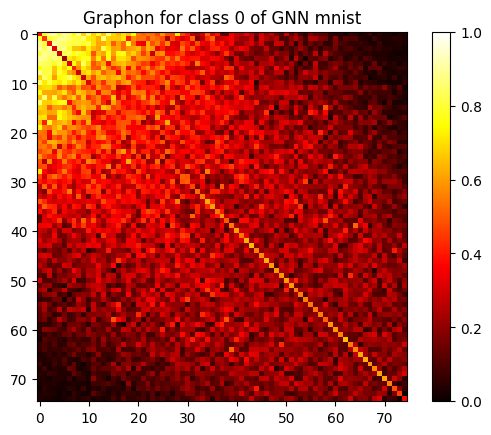

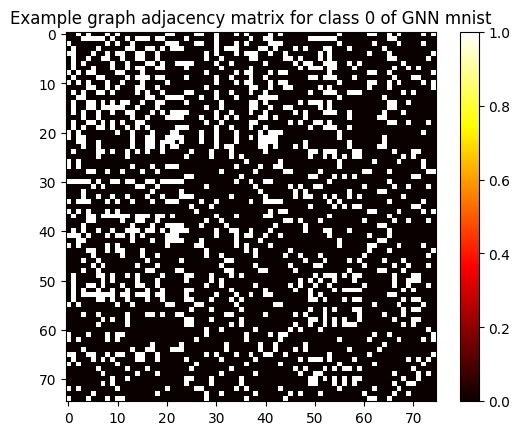

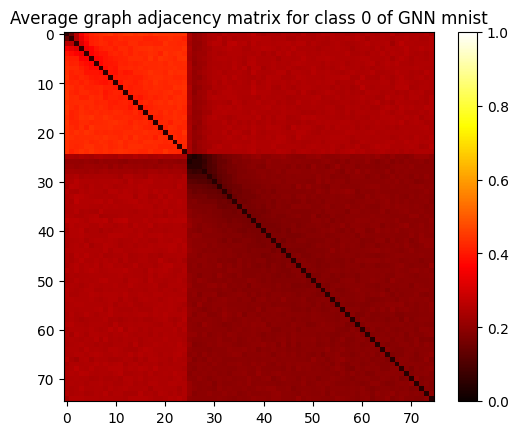

In [13]:
plt.imshow(gmixup_mnist.graphons[0], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 0 of GNN mnist")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(gmixup_mnist.base_dataset[gmixup_mnist.graphs_by_class[0][5]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 0 of GNN mnist")
plt.show()

g0_avg_adj = np.mean([nx.to_numpy_array(to_networkx(gmixup_mnist.base_dataset[graph_index])) for graph_index in gmixup_mnist.graphs_by_class[0]], axis=0)
plt.imshow(g0_avg_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Average graph adjacency matrix for class 0 of GNN mnist")
plt.show()

# Adding GMixup to a GCN for graph classification on REDDIT-BINARY dataset

In [14]:
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

In [15]:
def add_dummy_feature(data):
    # If data.x does not exist or data.num_features == 0, create a dummy feature
    if data.x is None or data.num_node_features == 0:
        data.x = torch.ones((data.num_nodes, 1), dtype=torch.float)
    return data

reddit_base = TUDataset(root='data', name='REDDIT-BINARY', transform=add_dummy_feature)

In [16]:
reddit_mixed = GMixupDataset(reddit_base, sample_num=10)

Generating graphons for 2 classes...

Generating graphon for class 0 with 10 graphs...


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Graphon for class 0 generated.
graphon avg = 0.0003030969819519669, original avg = 0.0002813815954141319. These should be close.

Generating graphon for class 1 with 10 graphs...


100%|██████████| 10/10 [00:00<00:00, 17.05it/s]

Graphon for class 1 generated.
graphon avg = 0.000994057976640761, original avg = 0.0008465218124911189. These should be close.



observe some characteristics of the two classes

In [17]:
print(f"Class 0:")
print(f"   degrees:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[0][i]])
    print(f"      {sorted(list(dict(g.degree()).values()), reverse=True)}")
print(f"   num_nodes:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[0][i]])
    print(f"      {len(list(dict(g.degree()).values()))}")


print(f"Class 1:")
print(f"   degrees:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][i]])
    print(f"      {sorted(list(dict(g.degree()).values()), reverse=True)}")
print(f"   num_nodes:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][i]])
    print(f"      {len(list(dict(g.degree()).values()))}")

Class 0:
   degrees:
      [498, 50, 40, 38, 36, 36, 26, 22, 20, 16, 16, 16, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [18]:
reddit_mixed.graphons[0]

array([[1.03414061e-06, 2.79892355e-01, 7.65258551e-01, ...,
        8.54564756e-02, 3.13365608e-02, 1.28558284e-04],
       [2.81039834e-01, 3.86102974e-01, 5.68295538e-01, ...,
        5.87818809e-02, 2.15687770e-02, 1.09997716e-04],
       [7.68396020e-01, 5.70285380e-01, 2.26737142e-01, ...,
        1.25248488e-02, 4.63021686e-03, 7.78114554e-05],
       ...,
       [8.53840262e-02, 5.87284639e-02, 1.25043988e-02, ...,
        7.57850671e-07, 7.61078240e-07, 7.62939464e-07],
       [3.12626362e-02, 2.15121601e-02, 4.60362993e-03, ...,
        7.57850671e-07, 7.61078240e-07, 7.62939464e-07],
       [5.37663691e-05, 5.15421561e-05, 4.76850910e-05, ...,
        7.57850671e-07, 7.61078240e-07, 7.62939464e-07]])

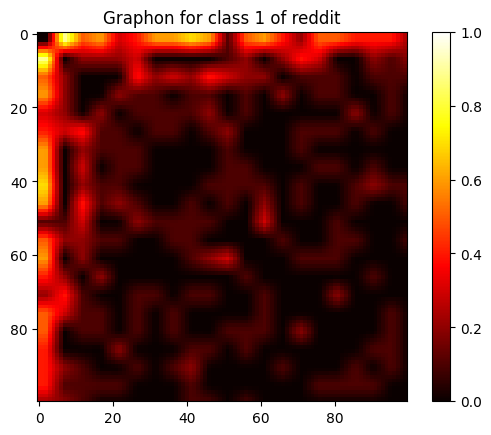

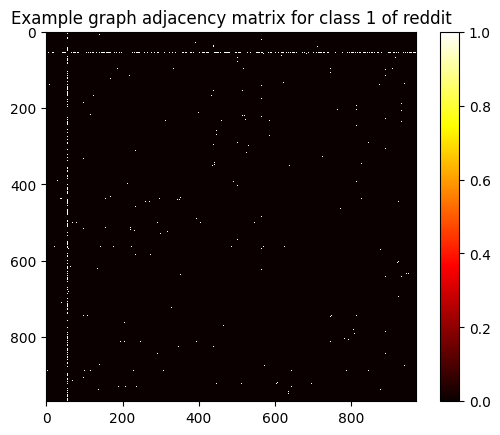

In [19]:
plt.imshow(reddit_mixed.graphons[1][:100, :100], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 1 of reddit")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][5]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 1 of reddit")
plt.show()

Generating 1 synthetic graph(s) for indices 1 and 1 with mixing parameter 0 and 218 nodes...
Synthetic graph(s) generated.

DiGraph with 218 nodes and 480 edges
graph real degrees:  [256, 26, 26, 24, 22, 12, 12, 12, 10, 10, 10, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Drawing Real Label 0 graph...
DiGraph with 218 nodes and 93 edges
graph gen degrees:  [57, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

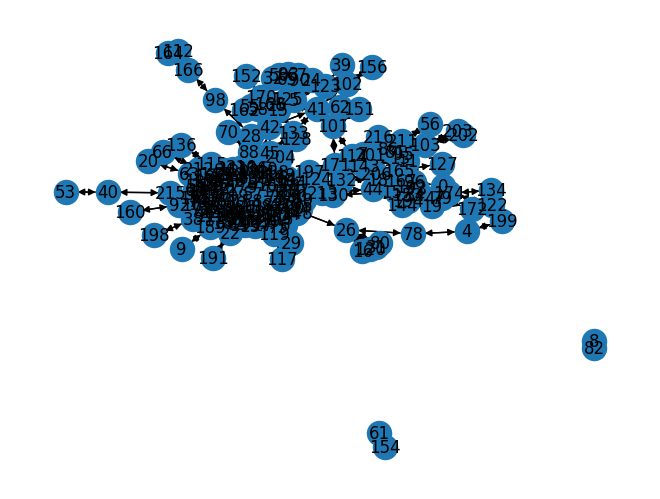

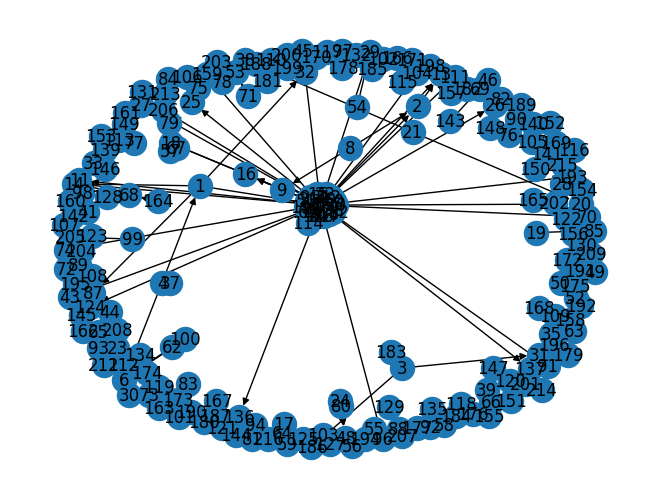

In [20]:
graph_real = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][0]])
graph_gen = to_networkx(reddit_mixed.generate_graphs(1, 1, 0, K=218, method='uniform'))

print(graph_real)
print("graph real degrees: ", sorted(list(dict(graph_real.degree()).values()), reverse=True))
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen degrees: ", sorted(list(dict(graph_gen.degree()).values()), reverse=True))
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

train baseline gcn on reddit binary data for comparison

In [21]:
import random

In [22]:
# dataset = list(reddit_base)
dataset = reddit_base
# random.shuffle(dataset)
train_num = int(len(dataset) * 0.5)
train_dataset = dataset[:train_num]
val_dataset = dataset[train_num:]

train_loader = torch_geometric.loader.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch_geometric.loader.DataLoader(val_dataset, batch_size=32)

In [23]:
dataset.num_node_features

1

In [24]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_mean_pool
import torch.nn.functional as F

class MyGIN(torch.nn.Module) :
    def __init__(self, in_channels=1, num_hidden=32, num_classes=1):
        super(MyGIN, self).__init__()

        nn1 = Sequential(Linear(in_channels, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(num_hidden)

        nn2 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(num_hidden)

        nn3 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(num_hidden)

        nn4 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(num_hidden)

        nn5 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(num_hidden)

        self.fc1 = Linear(num_hidden, num_hidden)
        self.fc2 = Linear(num_hidden, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        # x = global_add_pool(x, batch)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [25]:
model = MyGIN(in_channels=dataset.num_node_features, num_hidden=32, num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

def train(model, train_loader):
    model.train()
    for data in train_loader:
        # print( "data.y", data.y )
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        y = data.y.view(-1, 1)
        print(output, y, sep='\n')
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
    return model

def validate(model, val_loader) :
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for data in val_loader :
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        y = data.y.view(-1, 1)
        print(pred, y, sep="\n\n")
        loss += loss_fn(output, y).item() * data.num_graphs
        y = y.max(dim=1)[1]
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
    acc = correct / total
    loss = loss / total
    return acc, loss


In [27]:
for i in range(10) : # epochs
    model = train(model, train_loader)
    accuracy, loss = validate(model, val_loader)
    print(f"Epoch {i}: accuracy={accuracy}, loss={loss}")
    

/var/folders/61/jy1h8jns4t39ggk5639b7cs00000gn/T/ipykernel_71086/645803624.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 0: accuracy=1.0, loss=0.0
Epoch 1: accuracy=1.0, loss=0.0
Epoch 2: accuracy=1.0, loss=0.0
Epoch 3: accuracy=1.0, loss=0.0
Epoch 4: accuracy=1.0, loss=0.0
Epoch 5: accuracy=1.0, loss=0.0
Epoch 6: accuracy=1.0, loss=0.0
Epoch 7: accuracy=1.0, loss=0.0
Epoch 8: accuracy=1.0, loss=0.0
Epoch 9: accuracy=1.0, loss=0.0
